The 7 stages of machine learning pipeline are-
1) Business Problem Identification/Research Problem Identification
2) Collecting and Labeling the data
3) Evaluating the Data
4) Feature Engineering
5) Selecting and Training a Model
6) Evaluating the Model
7) Tuning and Deployment

## Phase 1: Business Problem Identification
For our case, we will be analysing the performance of missing data imputation techniques on Time Series Data

## Phase 2: Collecting and Labeling the Data
We will be using an accelerometer series dataset from a Kaggle Competition (https://www.kaggle.com/competitions/child-mind-institute-detect-sleep-states/overview)
Our dataset contains recordings of wrist-worn accelerometer data annotated with **two** event types: 
1. **onset** (the beginning of sleep)
2. **wakeup** (the end of sleep)

The original task of the competition is to detect the occurrence of these two events in the accelerometer series.

**Different from the original competition**, we will explore the impact of widely-used missing data imputation techniques vs machine-learning centered imputation techniques(more specifically, generative ai tool- e.g., GAN)

We will be using the training dataset of the competition to investigate the potential of imputation techniques.

We will be using train_series.parquet and train_series

train_series.parquet contains:

Several series where each series is a continuous recording of accelerometer data for a single subject spanning many days. The following columns are present in the dataset.

---> series_id - Unique identifier for each accelerometer series. 
---> step - An integer timestep for each observation within a series. 
---> timestamp - A corresponding datetime with ISO 8601 format %Y-%m-%dT%H:%M:%S%z. 
---> anglez - z-angle refers to the angle of the arm relative to the vertical axis of the body 
---> enmo - ENMO is the Euclidean Norm Minus One of all accelerometer signals, with negative values rounded to zero.

train_event.csv contains:

Sleep logs for series in the training set recording onset and wake events. The following columns are present in the dataset

---> series_id - Unique identifier for each series of accelerometer data in train_series.parquet. 
---> night - An enumeration of potential onset / wakeup event pairs. At most one pair of events can occur for each night. 
---> event - The type of event, whether onset or wakeup. 
---> step - An integer timestep for each observation within a series.
---> timestamp - The recorded time of occurence of the event in the accelerometer series.




## Phase 3: Evaluating the Data

### Extracting values from a column

We first check the train_events.csv

In [15]:
import pandas as pd
df_csv=pd.read_csv("D:/CIS 550/child-mind-institute-detect-sleep-states/train_events.csv")
print(df_csv)

          series_id  night   event      step                 timestamp
0      038441c925bb      1   onset    4992.0  2018-08-14T22:26:00-0400
1      038441c925bb      1  wakeup   10932.0  2018-08-15T06:41:00-0400
2      038441c925bb      2   onset   20244.0  2018-08-15T19:37:00-0400
3      038441c925bb      2  wakeup   27492.0  2018-08-16T05:41:00-0400
4      038441c925bb      3   onset   39996.0  2018-08-16T23:03:00-0400
...             ...    ...     ...       ...                       ...
14503  fe90110788d2     33  wakeup  560604.0  2017-09-06T04:07:00-0400
14504  fe90110788d2     34   onset  574620.0  2017-09-06T23:35:00-0400
14505  fe90110788d2     34  wakeup  581604.0  2017-09-07T09:17:00-0400
14506  fe90110788d2     35   onset       NaN                       NaN
14507  fe90110788d2     35  wakeup       NaN                       NaN

[14508 rows x 5 columns]


There are 14508 rows in **train_events.csv**. We also see missing values in instances. We will deal with missing values later. 
We check the datatype of each column.

In [16]:
df_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14508 entries, 0 to 14507
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   series_id  14508 non-null  object 
 1   night      14508 non-null  int64  
 2   event      14508 non-null  object 
 3   step       9585 non-null   float64
 4   timestamp  9585 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 566.8+ KB


We will break down the timestamp into year, month, day, hour and minute. 5 new columns will be added to our dataframe

In [18]:
## Decomposing timestamp to year, month, day, hour, minute

df_csv['timestamp'] = pd.to_datetime(df_csv['timestamp'], format='%Y-%m-%dT%H:%M:%S%z', utc=True)

# Extract year, month, day, and hour into separate columns
df_csv['year'] = df_csv['timestamp'].dt.year
df_csv['month'] = df_csv['timestamp'].dt.month
df_csv['day'] = df_csv['timestamp'].dt.day
df_csv['hour'] = df_csv['timestamp'].dt.hour
df_csv['minute'] = df_csv['timestamp'].dt.minute


df_csv

,series_id,night,event,step,timestamp,year,month,day,hour,minute
0,038441c925bb,1,onset,4992.0,2018-08-15 02:26:00+00:00,2018.0,8.0,15.0,2.0,26.0
1,038441c925bb,1,wakeup,10932.0,2018-08-15 10:41:00+00:00,2018.0,8.0,15.0,10.0,41.0
2,038441c925bb,2,onset,20244.0,2018-08-15 23:37:00+00:00,2018.0,8.0,15.0,23.0,37.0
3,038441c925bb,2,wakeup,27492.0,2018-08-16 09:41:00+00:00,2018.0,8.0,16.0,9.0,41.0
4,038441c925bb,3,onset,39996.0,2018-08-17 03:03:00+00:00,2018.0,8.0,17.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...
14503,fe90110788d2,33,wakeup,560604.0,2017-09-06 08:07:00+00:00,2017.0,9.0,6.0,8.0,7.0
14504,fe90110788d2,34,onset,574620.0,2017-09-07 03:35:00+00:00,2017.0,9.0,7.0,3.0,35.0
14505,fe90110788d2,34,wakeup,581604.0,2017-09-07 13:17:00+00:00,2017.0,9.0,7.0,13.0,17.0
14506,fe90110788d2,35,onset,NaN,NaT,NaN,NaN,NaN,NaN,NaN


###### Note: Missing values present in our dataset. We need to remove these. 

We now check the train_series.parquet

In [19]:
import pandas as pd
df_par=pd.read_parquet(r"D:/CIS 550/child-mind-institute-detect-sleep-states/train_series.parquet")
print(df_par)

              series_id    step                 timestamp     anglez    enmo
0          038441c925bb       0  2018-08-14T15:30:00-0400   2.636700  0.0217
1          038441c925bb       1  2018-08-14T15:30:05-0400   2.636800  0.0215
2          038441c925bb       2  2018-08-14T15:30:10-0400   2.637000  0.0216
3          038441c925bb       3  2018-08-14T15:30:15-0400   2.636800  0.0213
4          038441c925bb       4  2018-08-14T15:30:20-0400   2.636800  0.0215
...                 ...     ...                       ...        ...     ...
127946335  fe90110788d2  592375  2017-09-08T00:14:35-0400 -27.277500  0.0204
127946336  fe90110788d2  592376  2017-09-08T00:14:40-0400 -27.032499  0.0233
127946337  fe90110788d2  592377  2017-09-08T00:14:45-0400 -26.841200  0.0202
127946338  fe90110788d2  592378  2017-09-08T00:14:50-0400 -26.723900  0.0199
127946339  fe90110788d2  592379  2017-09-08T00:14:55-0400 -31.521601  0.0205

[127946340 rows x 5 columns]


There are 127946340 rows in **train_series.parquet**. We also see **no missing values** in instances, opposite to **train_event.csv**. We will deal with missing values later. 
We check the datatype of each column.

In [20]:
df_par.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127946340 entries, 0 to 127946339
Data columns (total 5 columns):
 #   Column     Dtype  
---  ------     -----  
 0   series_id  object 
 1   step       uint32 
 2   timestamp  object 
 3   anglez     float32
 4   enmo       float32
dtypes: float32(2), object(2), uint32(1)
memory usage: 3.3+ GB


We will break down the timestamp into year, month, day, hour and minute. 5 new columns will be added to our dataframe

In [21]:
## Decomposing timestamp to year, month, day, hour, minute

df_par['timestamp'] = pd.to_datetime(df_par['timestamp'], format='%Y-%m-%dT%H:%M:%S%z', utc=True)

# Extract year, month, day, and hour into separate columns
df_par['year'] = df_par['timestamp'].dt.year
df_par['month'] = df_par['timestamp'].dt.month
df_par['day'] = df_par['timestamp'].dt.day
df_par['hour'] = df_par['timestamp'].dt.hour
df_par['minute'] = df_par['timestamp'].dt.minute

df_par

,series_id,step,timestamp,anglez,enmo,year,month,day,hour,minute
0,038441c925bb,0,2018-08-14 19:30:00+00:00,2.636700,0.0217,2018,8,14,19,30
1,038441c925bb,1,2018-08-14 19:30:05+00:00,2.636800,0.0215,2018,8,14,19,30
2,038441c925bb,2,2018-08-14 19:30:10+00:00,2.637000,0.0216,2018,8,14,19,30
3,038441c925bb,3,2018-08-14 19:30:15+00:00,2.636800,0.0213,2018,8,14,19,30
4,038441c925bb,4,2018-08-14 19:30:20+00:00,2.636800,0.0215,2018,8,14,19,30
...,...,...,...,...,...,...,...,...,...,...
127946335,fe90110788d2,592375,2017-09-08 04:14:35+00:00,-27.277500,0.0204,2017,9,8,4,14
127946336,fe90110788d2,592376,2017-09-08 04:14:40+00:00,-27.032499,0.0233,2017,9,8,4,14
127946337,fe90110788d2,592377,2017-09-08 04:14:45+00:00,-26.841200,0.0202,2017,9,8,4,14
127946338,fe90110788d2,592378,2017-09-08 04:14:50+00:00,-26.723900,0.0199,2017,9,8,4,14


### Dropping Missing Values

Now we will observe how **train_events.csv** and **train_series.parquet** align.
**train_series.parquet** contains all accelerometer multiple readings per day over a duration of several days.
**train_events.csv** contains two crucial information for each day- when the subject went to sleep (ONSET) and when they woke up (WAKEUP).Also, **train_events.csv** contains missing values. We cannot work with those rows. These rows need to be dropped from **train_events.csv**. Additionally, we need to remove rows related to the dropped rows from **train_series.parquet**.

So we will 

1. Note down the **series_id** for the rows where there are missing values
2. Drop those rows
3. Create a new DataFrame with rows with no missing values
4. Save these new DataFrame as .csv or .parquet files.


The four steps mentioned above are done for both **train_events.csv** and **train_series.csv**.

In [22]:
import pandas as pd

##df_csv=pd.read_csv("D:/CIS 550/child-mind-institute-detect-sleep-states/train_events.csv")
'''
Note: We must make sure we are using the dataframe with expanded timestamp
'''
original_size=df_csv.shape[0]

#copied to retain original dataframe
df_csv_copy=df_csv

# Find rows with missing values in original csv train_events.csv file
missing_rows = df_csv[df_csv.isnull().any(axis=1)]
missing_size=missing_rows.shape[0]

# Store the 'series_id' values in a set
missing_id_set = set(missing_rows['series_id'])
series_missing_list=list(missing_id_set)


for i in range(0,len(series_missing_list)):
#     print(series_missing_list[i])
    # Drop rows where the value in column 'series id' is 'xyz'
    df_csv_copy = df_csv_copy[df_csv_copy['series_id'] != series_missing_list[i]]

print(df_csv_copy.shape[0])
print(df_csv_copy)
print(f"Remaining rows is {df_csv.shape[0]-df_csv_copy.shape[0]}")

1562
          series_id  night   event      step                 timestamp  \
398    08db4255286f      1   onset   11988.0 2018-11-06 06:39:00+00:00   
399    08db4255286f      1  wakeup   14388.0 2018-11-06 09:59:00+00:00   
400    08db4255286f      2   onset   28680.0 2018-11-07 05:50:00+00:00   
401    08db4255286f      2  wakeup   31320.0 2018-11-07 09:30:00+00:00   
402    08db4255286f      3   onset   44184.0 2018-11-08 03:22:00+00:00   
...             ...    ...     ...       ...                       ...   
11673  d5e47b94477e     21  wakeup  356172.0 2017-11-30 13:41:00+00:00   
11674  d5e47b94477e     22   onset  366756.0 2017-12-01 04:23:00+00:00   
11675  d5e47b94477e     22  wakeup  373176.0 2017-12-01 13:18:00+00:00   
11676  d5e47b94477e     23   onset  383616.0 2017-12-02 03:48:00+00:00   
11677  d5e47b94477e     23  wakeup  390096.0 2017-12-02 12:48:00+00:00   

         year  month   day  hour  minute  
398    2018.0   11.0   6.0   6.0    39.0  
399    2018.0   11.0

In [23]:
import pandas as pd
# df_par=pd.read_parquet(r"D:/CIS 550/child-mind-institute-detect-sleep-states/train_series.parquet")

'''
Note: We must make sure we are using the dataframe with expanded timestamp
'''
original_size=df_par.shape[0]

#copied to retain original dataframe
df_par_copy=df_par

# Find rows with missing values in original csv train_events.csv file
missing_rows = df_csv[df_csv.isnull().any(axis=1)]
missing_size=missing_rows.shape[0]

# Store the 'series_id' values in a set
missing_id_set = set(missing_rows['series_id'])
series_missing_list=list(missing_id_set)


for i in range(0,len(series_missing_list)):
#     print(series_missing_list[i])
    # Drop rows where the value in column 'series_id' is 'xyz'
    df_par_copy = df_par_copy[df_par_copy['series_id'] != series_missing_list[i]]

print(df_par_copy.shape[0])
print(df_par_copy)
print(f"Dropped rows is {df_par.shape[0]-df_par_copy.shape[0]}")

14334840
              series_id    step                 timestamp     anglez    enmo  \
3770820    08db4255286f       0 2018-11-05 14:00:00+00:00 -30.845301  0.0447   
3770821    08db4255286f       1 2018-11-05 14:00:05+00:00 -34.181801  0.0443   
3770822    08db4255286f       2 2018-11-05 14:00:10+00:00 -33.877102  0.0483   
3770823    08db4255286f       3 2018-11-05 14:00:15+00:00 -34.282101  0.0680   
3770824    08db4255286f       4 2018-11-05 14:00:20+00:00 -34.385799  0.0768   
...                 ...     ...                       ...        ...     ...   
103353655  d5e47b94477e  395815 2017-12-02 20:44:35+00:00 -10.064100  0.1552   
103353656  d5e47b94477e  395816 2017-12-02 20:44:40+00:00 -10.006700  0.1139   
103353657  d5e47b94477e  395817 2017-12-02 20:44:45+00:00  -3.328600  0.1245   
103353658  d5e47b94477e  395818 2017-12-02 20:44:50+00:00  -5.903100  0.1363   
103353659  d5e47b94477e  395819 2017-12-02 20:44:55+00:00 -11.691100  0.0995   

           year  month  day  h

In [24]:
df_par_copy.to_parquet('clean_train_par.parquet',index=False)

In [25]:
df_csv_copy.to_csv('clean_train_csv.csv',index=False)

**clean_train_par.parquet** and **clean_train_csv** contain no missing values. 

##### Note: Our dataset originally has 277 series. 240 series had missing values. Dropping missing values we have 37 series in cleaned data.

train_series.parquet has 127946340 instances. After removing the missing value instances, we have 14334840 rows.
train_events.csv has 14508 instances. After removing the missing value instances, we have 1562 rows.


Now we can work on visualizing our data. 

For each of the 37 series, we will see how many instances are associated with it in **clean_train_par.parquet** and **clean_train_csv.csv**

In [27]:
'''
COUNTING ALL UNIQUE SERIES from the training dataset and then matching them up with the train_csv to find 
when the subject with corresponding series id slept (ONSET) and woke up for one DAY/NIGHT

'''

'''
Additional Notes: all values are even. So for one night/day we have two record (ONSET and AWAKE) 
'''

df_clean_par=pd.read_parquet(r"D:\CIS 550\child-mind-institute-detect-sleep-states\clean_train_par.parquet")

total_subjects=df_clean_par.series_id.unique()

print('For train_series.parquet')
data_par = {
    'series_id': [],
    'num_of_instances': []
}

for subject in total_subjects:

    # Select rows where 'series_id' is '03d92c9f6f8a'
    desired_value = subject
    filtered_rows = df_clean_par[df_clean_par['series_id'] == desired_value]
    

    # Display the selected rows
    print(subject + "    "+ str(filtered_rows.shape[0]))
    data_par['series_id'].append(subject)
    data_par['num_of_instances'].append(filtered_rows.shape[0])

df_par_count=pd.DataFrame(data_par)
df_par_count.to_csv('clean_data_par_count.csv',index=False)

#############################################################################    
print('For train_events.csv')

data_csv = {
    'series_id': [],
    'num_of_instances': []
}
df_clean_csv=pd.read_csv(r"D:/CIS 550/child-mind-institute-detect-sleep-states/clean_train_csv.csv")


for subject in total_subjects:

    # Select rows where 'series_id' is '03d92c9f6f8a'
    desired_value = subject
    filtered_rows = df_clean_csv[df_clean_csv['series_id'] == desired_value]
    

    # Display the selected rows
    print(subject + "    "+ str(filtered_rows.shape[0]))
    data_csv['series_id'].append(subject)
    data_csv['num_of_instances'].append(filtered_rows.shape[0])

df_csv_count=pd.DataFrame(data_csv)
df_csv_count.to_csv('clean_data_csv_count.csv',index=False)


For train_series.parquet
08db4255286f    440280
0a96f4993bd7    256860
0cfc06c129cc    384660
1087d7b0ff2e    410940
10f8bc1f7b07    392400
18b61dd5aae8    495540
29c75c018220    464220
31011ade7c0a    564840
3452b878e596    535500
349c5562ee2c    37080
3664fe9233f9    379980
483d6545417f    287460
55a47ff9dc8a    412740
5acc9d63b5fd    407880
5f94bb3e1bed    404280
655f19eabf1e    387360
67f5fc60e494    376380
72bbd1ac3edf    390960
76237b9406d5    412920
7822ee8fe3ec    408060
89bd631d1769    429300
8e32047cbc1f    405540
939932f1822d    414540
9ee455e4770d    389880
a596ad0b82aa    604440
a9a2f7fac455    634680
a9e5f5314bcb    155160
af91d9a50547    411840
b364205aba43    401940
c535634d7dcd    136080
c6788e579967    395640
c68260cc9e8f    310860
ca730dbf521d    401580
d150801f3145    399060
d25e479ecbb7    362520
d515236bdeec    235620
d5e47b94477e    395820
For train_events.csv
08db4255286f    50
0a96f4993bd7    30
0cfc06c129cc    42
1087d7b0ff2e    48
10f8bc1f7b07    46
18b61dd5a

Converting parquet to csv file and excel to track down things better (personal opinion)

series_id==349c5562ee2c has least number of instances. We will observe the pattern for this series.

In [31]:
### Filter for visualization

filtered_df_par = df_clean_par[df_clean_par['series_id'] == '349c5562ee2c']
filtered_df_csv = df_clean_csv[df_clean_csv['series_id'] == '349c5562ee2c']

print(filtered_df_par)
print(filtered_df_csv)

            series_id   step                 timestamp     anglez    enmo  \
3945240  349c5562ee2c      0 2019-02-08 17:00:00+00:00 -88.683701  0.0000   
3945241  349c5562ee2c      1 2019-02-08 17:00:05+00:00 -88.683701  0.0000   
3945242  349c5562ee2c      2 2019-02-08 17:00:10+00:00 -88.683701  0.0000   
3945243  349c5562ee2c      3 2019-02-08 17:00:15+00:00 -88.683701  0.0000   
3945244  349c5562ee2c      4 2019-02-08 17:00:20+00:00 -88.683701  0.0000   
...               ...    ...                       ...        ...     ...   
3982315  349c5562ee2c  37075 2019-02-10 20:29:35+00:00   1.075100  0.0128   
3982316  349c5562ee2c  37076 2019-02-10 20:29:40+00:00  -0.874000  0.0176   
3982317  349c5562ee2c  37077 2019-02-10 20:29:45+00:00  -1.132200  0.0165   
3982318  349c5562ee2c  37078 2019-02-10 20:29:50+00:00   0.540100  0.0145   
3982319  349c5562ee2c  37079 2019-02-10 20:29:55+00:00   0.883300  0.0168   

         year  month  day  hour  minute  
3945240  2019      2    8    17  

#### NOTE

In filtered_df_csv from **train_event.csv**-
    filtered_df_csv['event']==1, filtered_df_csv['step']==7536. This refers that subject felt asleep at step 7536 from point of starting recording. And wokeup at step 12816 from the point of starting recording.
    So,
        onset ---> wakeup : implies subject is SLEEPING
        wakeup ---> onset : implies subject is NOT SLEEPING

We plot the datapoints of filtered_df_csv in a graph to visualize

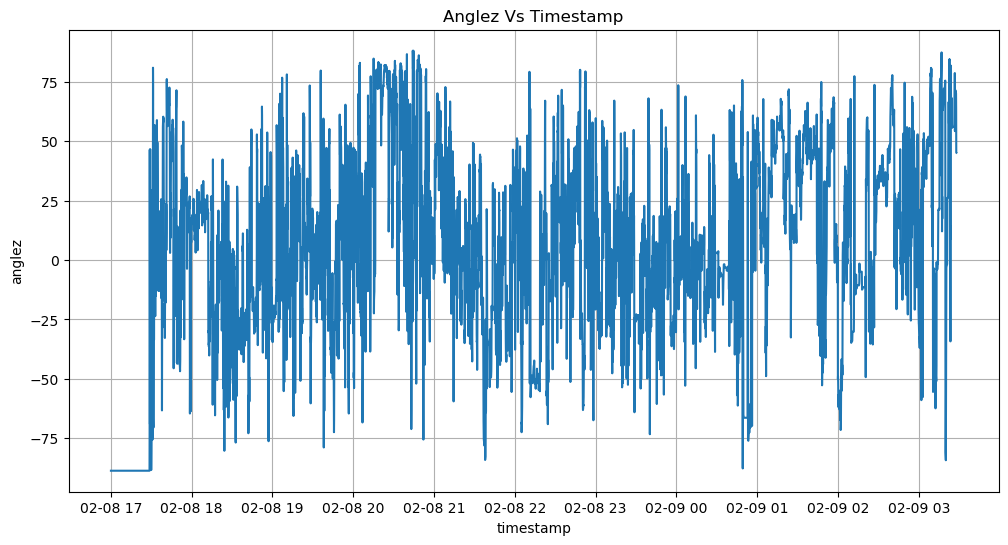

In [38]:

subset_df = filtered_df_par[0:7536]

import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Replace 'timestamp' and 'value' with the actual column names from your DataFrame
x = subset_df['timestamp']
y = subset_df['anglez']

plt.figure(figsize=(12, 6))
plt.plot(x, y)
plt.title("Anglez Vs Timestamp")
plt.xlabel("timestamp")
plt.ylabel("anglez")
plt.grid(True)

plt.show()

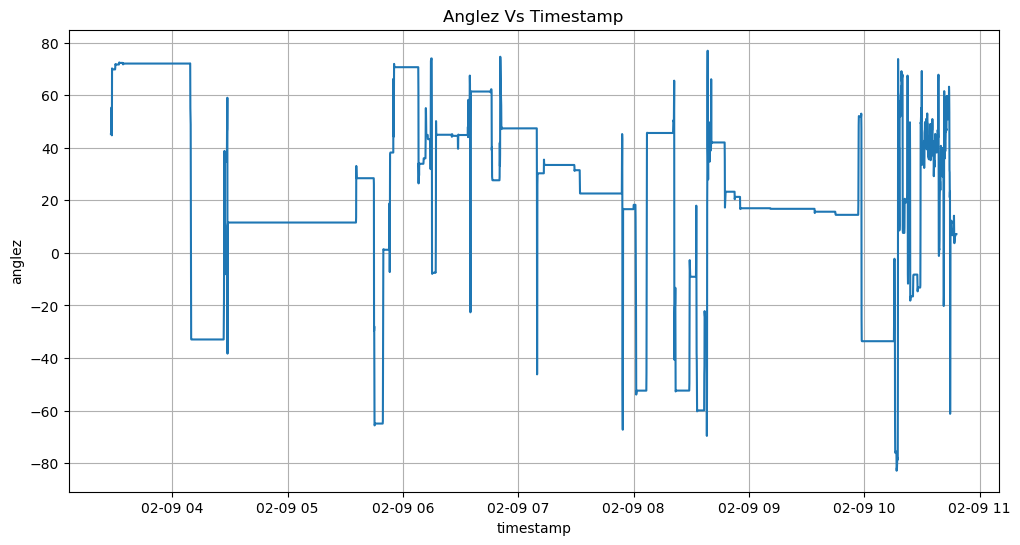

In [37]:

subset_df = filtered_df_par[7536:12816]

import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Replace 'timestamp' and 'value' with the actual column names from your DataFrame
x = subset_df['timestamp']
y = subset_df['anglez']

plt.figure(figsize=(12, 6))
plt.plot(x, y)
plt.title("Anglez Vs Timestamp")
plt.xlabel("timestamp")
plt.ylabel("anglez")
plt.grid(True)

plt.show()

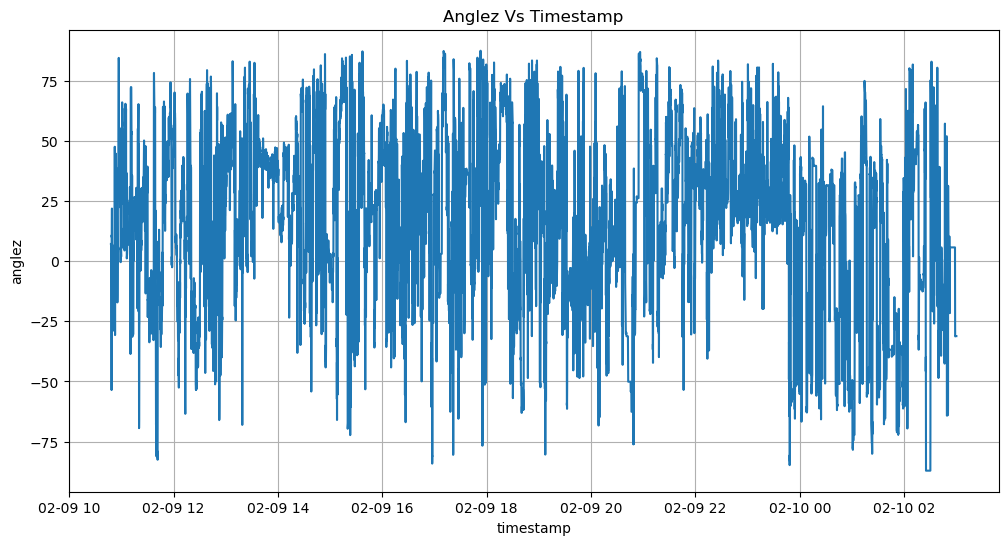

In [39]:

subset_df = filtered_df_par[12816:24480]

import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Replace 'timestamp' and 'value' with the actual column names from your DataFrame
x = subset_df['timestamp']
y = subset_df['anglez']

plt.figure(figsize=(12, 6))
plt.plot(x, y)
plt.title("Anglez Vs Timestamp")
plt.xlabel("timestamp")
plt.ylabel("anglez")
plt.grid(True)

plt.show()

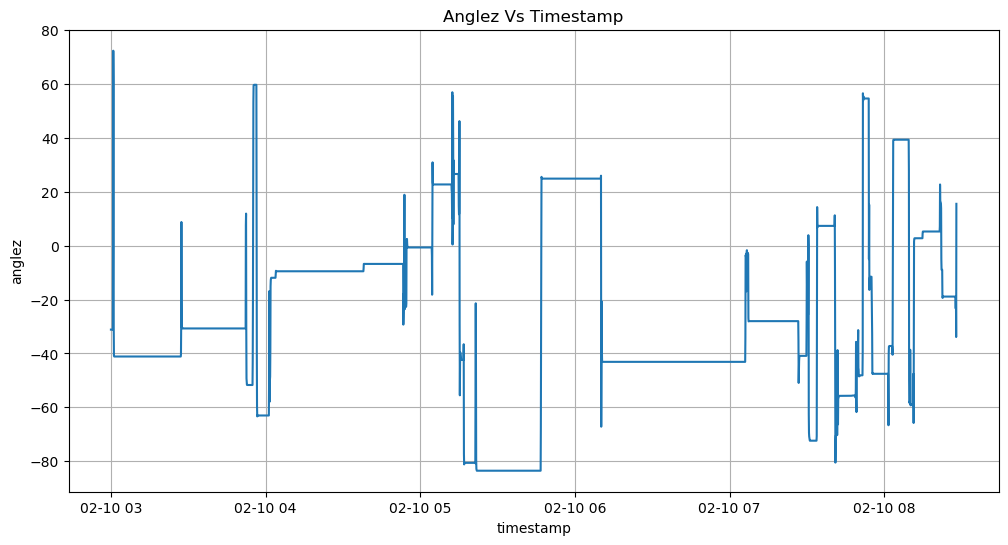

In [41]:

subset_df = filtered_df_par[24480:28416]

import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Replace 'timestamp' and 'value' with the actual column names from your DataFrame
x = subset_df['timestamp']
y = subset_df['anglez']

plt.figure(figsize=(12, 6))
plt.plot(x, y)
plt.title("Anglez Vs Timestamp")
plt.xlabel("timestamp")
plt.ylabel("anglez")
plt.grid(True)

plt.show()

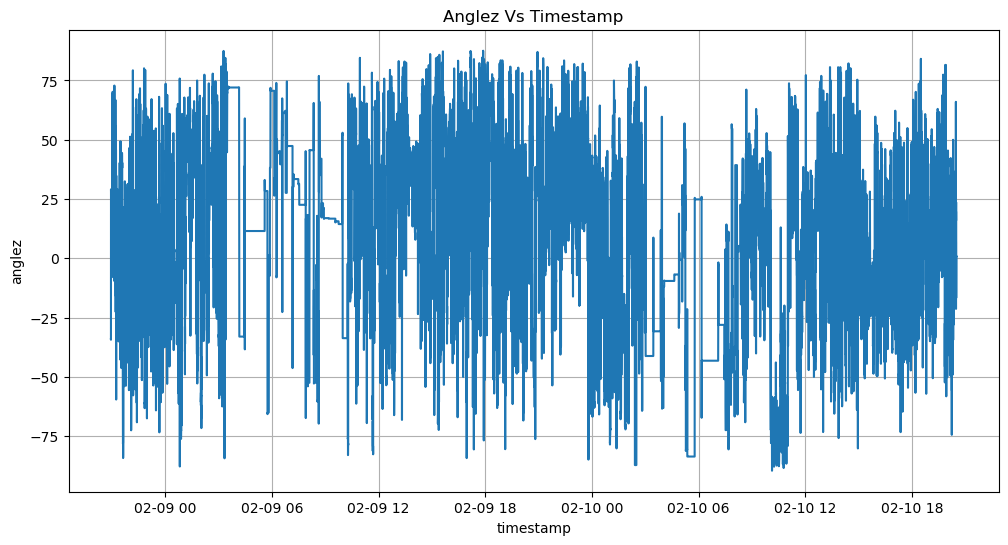

In [43]:

subset_df = filtered_df_par[2841:]

import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Replace 'timestamp' and 'value' with the actual column names from your DataFrame
x = subset_df['timestamp']
y = subset_df['anglez']

plt.figure(figsize=(12, 6))
plt.plot(x, y)
plt.title("Anglez Vs Timestamp")
plt.xlabel("timestamp")
plt.ylabel("anglez")
plt.grid(True)

plt.show()

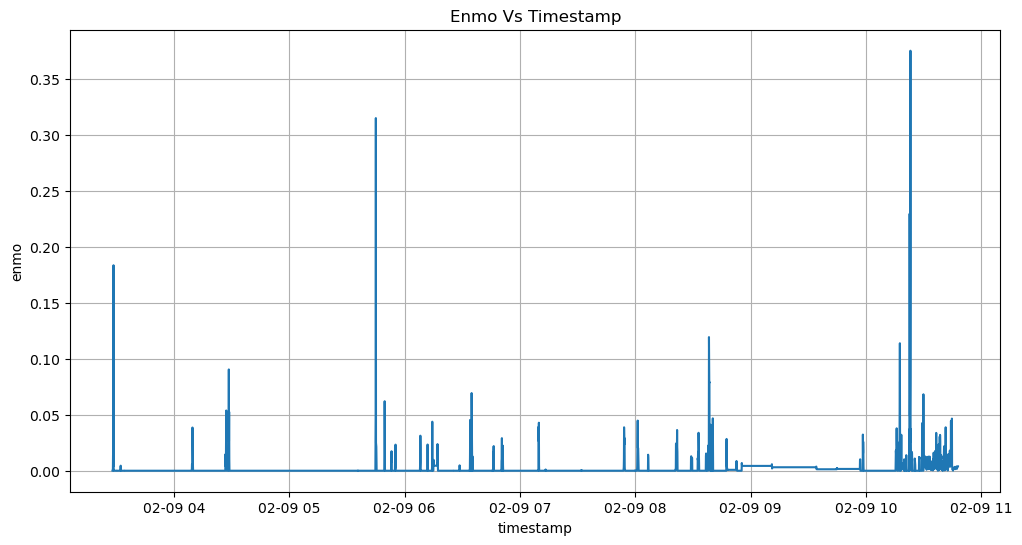

In [44]:

subset_df = filtered_df_par[7536:12816]

import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Replace 'timestamp' and 'value' with the actual column names from your DataFrame
x = subset_df['timestamp']
y = subset_df['enmo']

plt.figure(figsize=(12, 6))
plt.plot(x, y)
plt.title("Enmo Vs Timestamp")
plt.xlabel("timestamp")
plt.ylabel("enmo")
plt.grid(True)

plt.show()

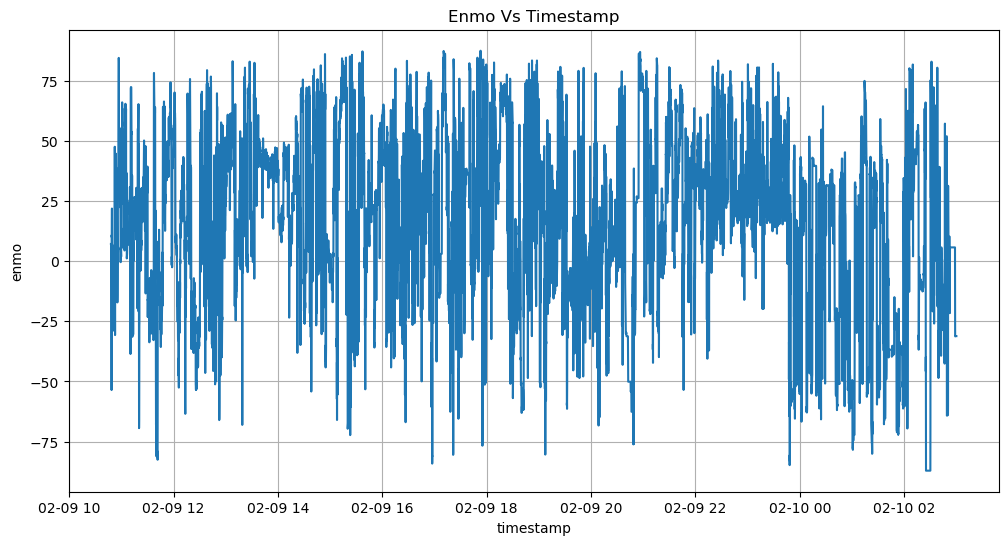

In [45]:

subset_df = filtered_df_par[12816:24480]

import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Replace 'timestamp' and 'value' with the actual column names from your DataFrame
x = subset_df['timestamp']
y = subset_df['anglez']

plt.figure(figsize=(12, 6))
plt.plot(x, y)
plt.title("Enmo Vs Timestamp")
plt.xlabel("timestamp")
plt.ylabel("enmo")
plt.grid(True)

plt.show()

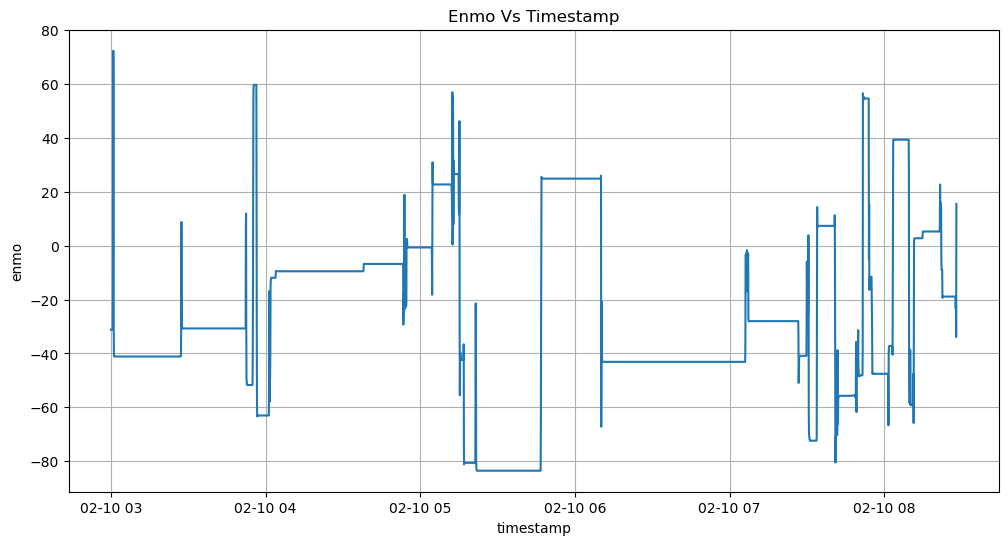

In [46]:

subset_df = filtered_df_par[24480:28416]

import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Replace 'timestamp' and 'value' with the actual column names from your DataFrame
x = subset_df['timestamp']
y = subset_df['anglez']

plt.figure(figsize=(12, 6))
plt.plot(x, y)
plt.title("Enmo Vs Timestamp")
plt.xlabel("timestamp")
plt.ylabel("enmo")
plt.grid(True)

plt.show()

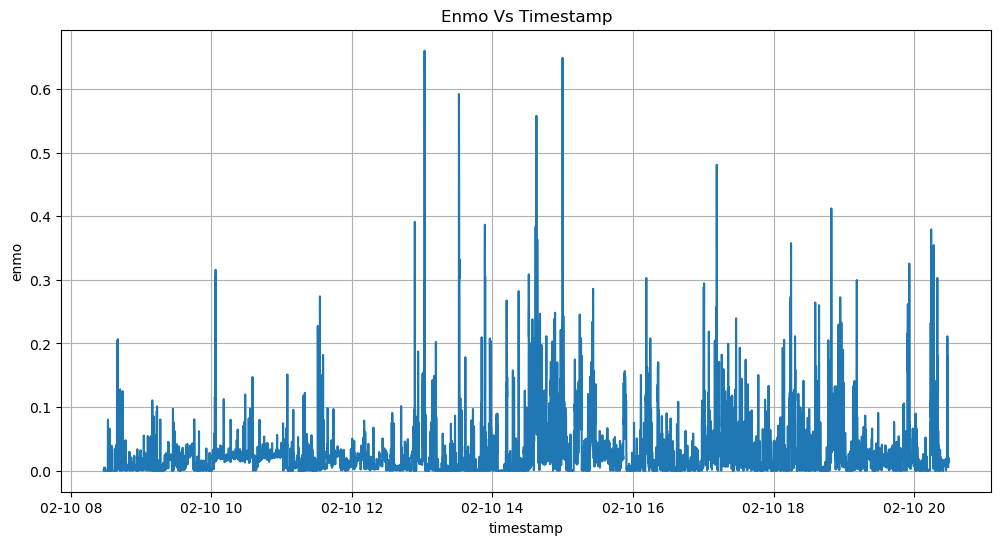

In [47]:

subset_df = filtered_df_par[28416:]

import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Replace 'timestamp' and 'value' with the actual column names from your DataFrame
x = subset_df['timestamp']
y = subset_df['enmo']

plt.figure(figsize=(12, 6))
plt.plot(x, y)
plt.title("Enmo Vs Timestamp")
plt.xlabel("timestamp")
plt.ylabel("enmo")
plt.grid(True)

plt.show()